# Notebook for comparing the model of dipole vs. quadrupole for ca. 1083-1084 Ma

- Sears, J. W. (2022). Challenging the dipolar paradigm for Proterozoic Earth. Presented based on debatable geologic links that the Siberia craton and the southwestern Laurentia craton were connected in the early Proterozoic. Based on this connection he argued that the combined paleomagnetic data from the two cratons at the time indicate that the geomagnetic field at the time was likely to be quadrupole dominated.

- Gong et al., 2023, on the other hand, argued that a dipole model is better, if not equally, good fit for the available paleomagnetic directional data from Laurentia, and Laurentia+Baltica through the Proterozoic. Their model is based on a frequentist's approach which exhaust search for the dipole or quadrupole configuration by grids on a sphere surface that result in the smallest least squares misfit for the observed paleomagnetic directional data. 

## import python libraries

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag

import cartopy.crs as ccrs

from bayesian_pep import*
import theano.tensor as T

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
d2r = np.pi/180
r2d = 180/np.pi

## Let's first see what a dipole and a quadrupole look like

- according to Knappe, 1980, On Modeling Magnetic Fields on a Sphere with Dipoles and Quadrupoles, we can visualize the inclinations and declinations of a dipole and a quadrupole on a sphere surface as follows

In [3]:
# Define the polar coordinates
lons = np.linspace(0, 360, 50) # in degrees
lats = np.linspace(-90, 90, 25) # in degrees
lons, lats = np.meshgrid(lons, lats) # make a grid

### dipole

In [4]:
# calculate inclination at each point
dipole_incs = np.degrees(np.arctan(2*np.tan(np.radians(lats)))) # in degrees

# delcination does not matter for the dipole case since everywhere it should be pointing north

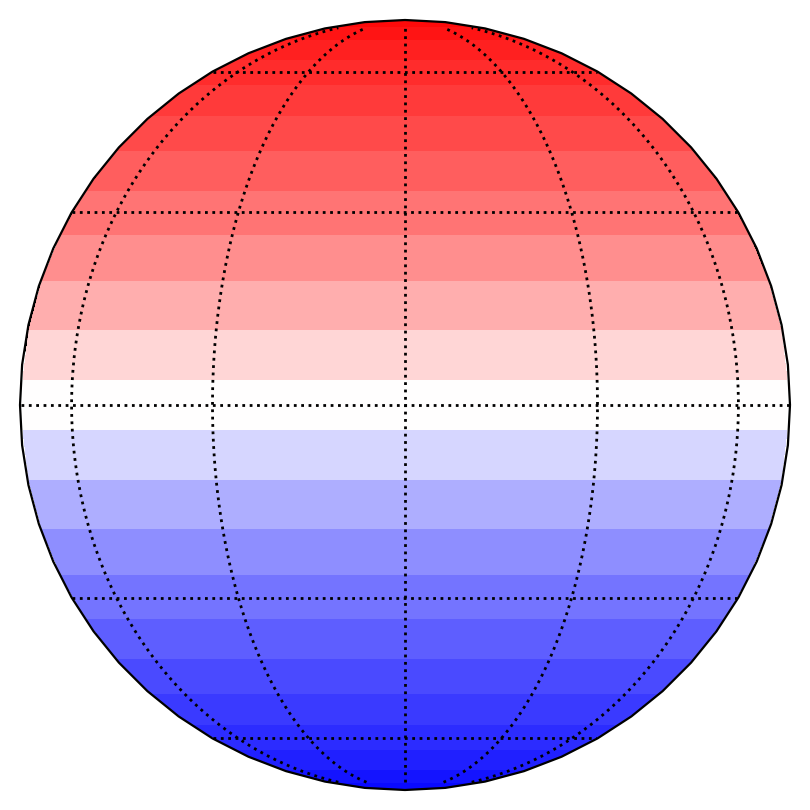

In [5]:
# illustrate the inclinations

ax = ipmag.make_orthographic_map(figsize=(5,5), central_latitude=0, central_longitude=0)

ax.pcolormesh(lons, lats, dipole_incs, vmin=np.min(dipole_incs), vmax=np.max(dipole_incs), 
              cmap='bwr', transform=ccrs.PlateCarree())

plt.show()

### Let's illustrate the quadrupole model

- according to Knapp's definition, a quadrupole can be characterized by the direction in which the reversed dipole is displaced from the forward one. This classification can be done using the characteristic angle 2$\omega$ which is the angle at the normal pole between two reversed poles. If this angle is 180, then we have a linear quadrupole: 

<img src="linear_quadrupole.png" alt="isolated" width="600"/>

If this angle is neither zero or multiple of 90, then we have a rhombic quadrupole:
<img src="rhombic_quadrupole.png" alt="isolated" width="800"/>

All images are taken from Knapp, 1980.


- if the angle is 90, then we have a normal quadrupole, which we will illustrate below with code. 

<img src="normal_quadrupole.png" alt="isolated" width="200"/>


In [6]:
# makes a function that calculates the inclination for
# a given longitude and latitude based on a normal quadrupole model
def normal_quadrupole_inclination(lat, lon):
    '''
    input: lat, lon in degrees
    output: calcualted inclination for a normal quadrupole model in degrees
    '''
    lat = lat*d2r
    lon = lon*d2r
    colat = np.pi/2 - lat
    tan_I = -1.5*(np.sin(colat)*np.cos(2*lon))/(1-np.sin(colat)**2*np.cos(2*lon)**2)**0.5
    I = np.degrees(np.arctan(tan_I))
    return I

# makes a function that calculates the inclination for 
# a given longitude and latitude based on a negative linear quadrupole model
def negative_linear_quadrupole_inclination(lat, lon):
    '''
    input: lat, lon in degrees
    output: calcualted inclination for a negative linear quadrupole model in degrees
    '''
    lat = lat*d2r
    lon = lon*d2r
    colat = np.pi/2 - lat
    tan_I = (3*np.cos(2*colat)+1)/np.abs((2*np.sin(2*colat)))
    I = np.degrees(np.arctan(tan_I))
    return I

In [7]:
# calculate inclination at each point
normal_quadrupole_incs = normal_quadrupole_inclination(lats, lons)
negative_quadrupole_incs = negative_linear_quadrupole_inclination(lats, lons)

# normal_quadrupole_incs

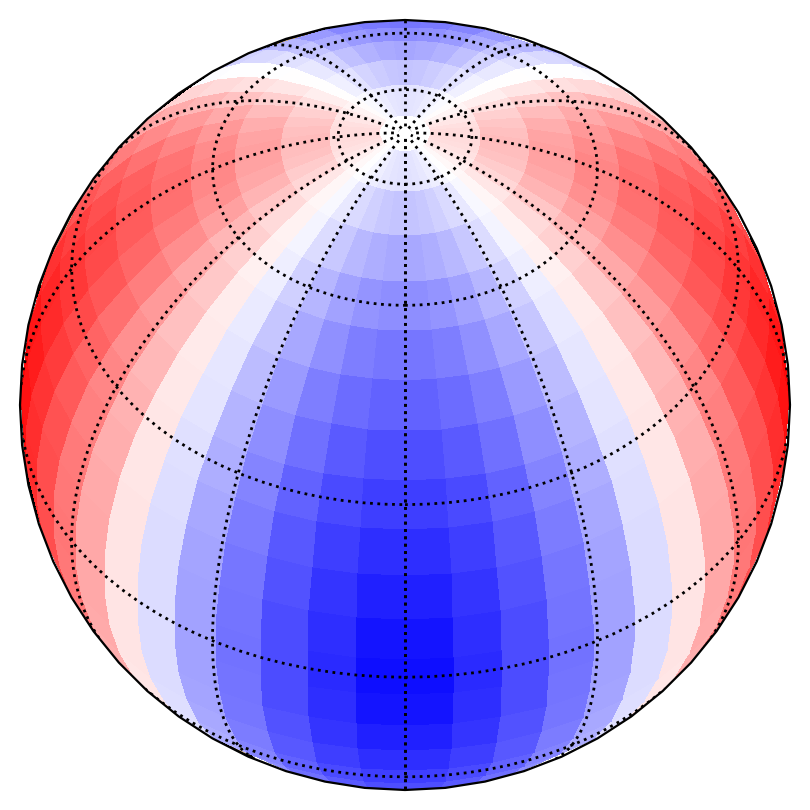

In [8]:
# illustrate the inclinations of a normal quadrupole

ax = ipmag.make_orthographic_map(figsize=(5,5), central_latitude=45, central_longitude=180)

ax.pcolormesh(lons, lats, normal_quadrupole_incs, 
              vmin=np.min(normal_quadrupole_incs), vmax=np.max(normal_quadrupole_incs), 
              cmap='bwr', transform=ccrs.PlateCarree())

plt.show()

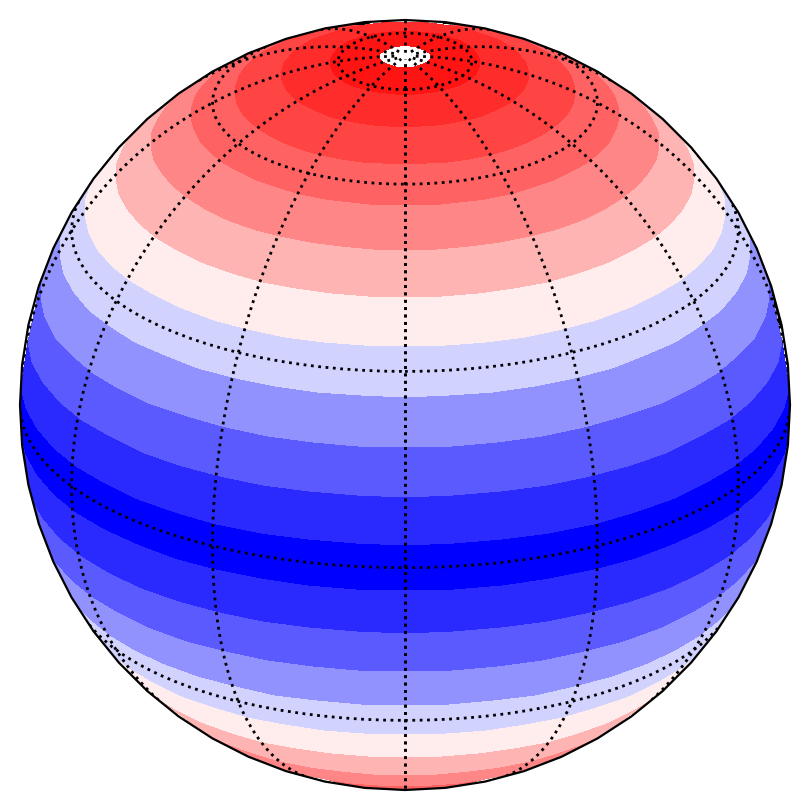

In [9]:
# illustrate the inclinations of a negative linear quadrupole

ax = ipmag.make_orthographic_map(figsize=(5,5), central_latitude=25, central_longitude=180)

ax.pcolormesh(lons, lats, negative_quadrupole_incs, 
              vmin=np.min(negative_quadrupole_incs), vmax=np.max(negative_quadrupole_incs), 
              cmap='bwr', transform=ccrs.PlateCarree())

plt.show()

## The goal is to see whether a dipole or a normal quadrupole model better fits the observed directions at different locations on the Earth's surface

- The ca. 1084 Ma Michipicotan pole and the ca. 1082 Ma Cardenas Basalt pole presents us with this opportunity to investigate the models since they are close in time but ~2000 km apart in space. 

- The age of the Michipicoten Island Formation pole is bracketed in age between 1084.35 ± 0.20 Ma and 1083.52 ± 0.23 Ma.

- The age of the Cardenas Basalt pole is dated to be 1082.18 ± 1.25 Ma.

In [10]:
# Michipicoten site location
Mich_slat = 47.7
Mich_slon = 360-85.7

# Michipicoten site directional data
Mich_dir_dec = 287.6
Mich_dir_inc = 10.3
Mich_dir_a95 = 5.4
Mich_dir_k = 35.2

# Cardenas Basalt site location
CB_slat = 36.1
CB_slon = 360-112.0

# Cardenas Basalt site directional data
CB_dir_dec = 268.5
CB_dir_inc = 46.4
CB_dir_a95 = 7.9
CB_dir_k = 20.2

# Michipicoten paleomagnetic pole data
Mich_plon = 174.7
Mich_plat = 17.0
Michi_A95 = 4.4

# Cardenas Basalt paleomagnetic pole data
CB_plon = 183.9
CB_plat = 15.9
CB_A95 = 7.4

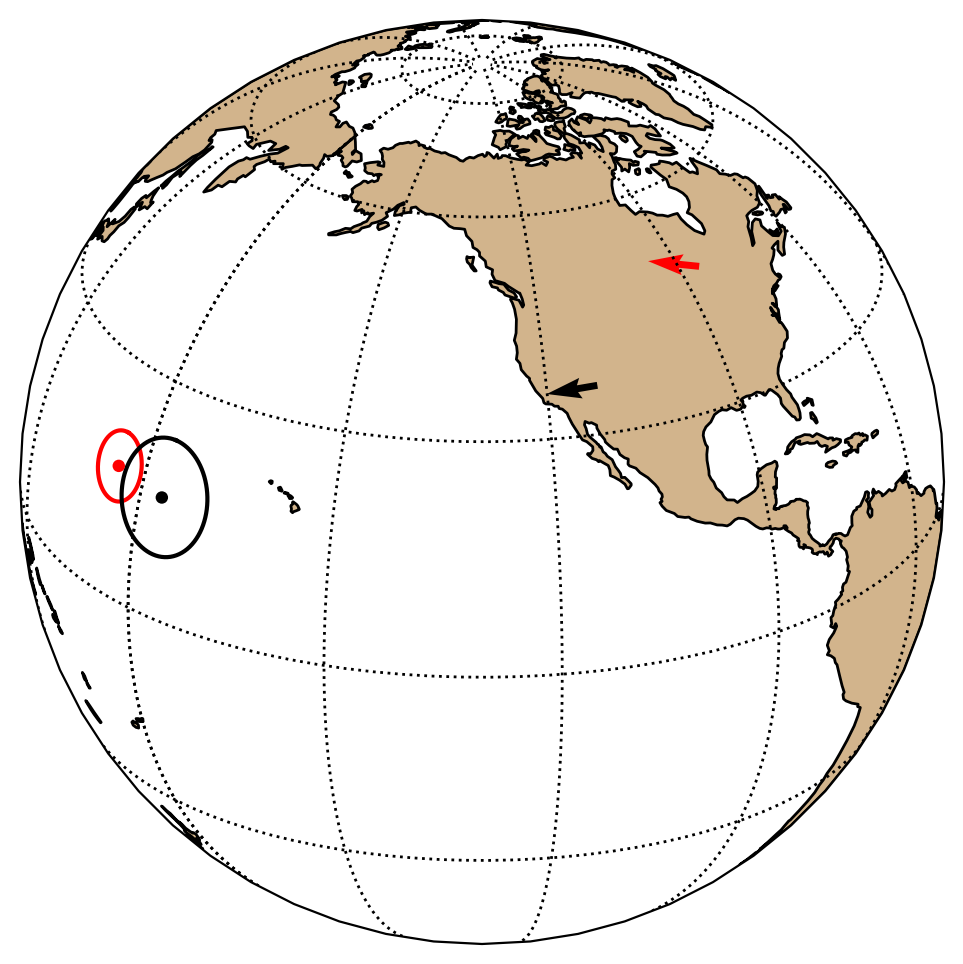

In [11]:
ax = ipmag.make_orthographic_map(figsize=(6,6), central_latitude=25, central_longitude=-130)

# now let's plot the declination of the directions at each site as a vector

ax.quiver(np.array([Mich_slon]), np.array([Mich_slat]), np.array([np.sin(np.radians(Mich_dir_dec))]), np.array([np.cos(np.radians(Mich_dir_dec))]),
            color='r', transform=ccrs.PlateCarree())
ax.quiver(np.array([CB_slon]), np.array([CB_slat]), np.array([np.sin(np.radians(CB_dir_dec))]), np.array([np.cos(np.radians(CB_dir_dec))]),
            color='k', transform=ccrs.PlateCarree())
# ax.plot([-174.7, Mich_slon], [17.0, Mich_slat], color='k', transform=ccrs.Geodetic())

ipmag.plot_pole(ax, Mich_plon, Mich_plat, Michi_A95, color='r', edgecolor='none')
ipmag.plot_pole(ax, CB_plon, CB_plat, CB_A95, color='k', edgecolor='none')
plt.show()

### Make pymc3 compatible functions

In [12]:
def calculate_dipole_azimuth(observer_latitude, observer_longitude, target_latitude, target_longitude):
    '''
    input: observer_latitude, observer_longitude, target_latitude, target_longitude in degrees
    output: calculated azimuth(declination) in degrees
    '''
    # Convert degrees to radians
    observer_latitude = observer_latitude*d2r
    observer_longitude = observer_longitude*d2r
    target_latitude = target_latitude*d2r
    target_longitude = target_longitude*d2r

    # Calculate the difference in longitudes
    delta_longitude = target_longitude - observer_longitude

    # Calculate azimuth using spherical trigonometry
    x = np.sin(delta_longitude)
    y = np.cos(observer_latitude) * np.tan(target_latitude) - np.sin(observer_latitude) * np.cos(delta_longitude)
    azimuth = np.arctan(x/y)*r2d % 180 + 180
    
    return azimuth

def calc_angle(lon1, lat1, lon2, lat2):
    '''
    input: lon1, lat1, lon2, lat2 in degrees
    output: calculated angle between the two locations in degrees
    '''
    cart1 = spherical_to_cartesian(lon1, lat1)
    cart2 = spherical_to_cartesian(lon2, lat2)
    angle = np.arccos(np.dot(cart1, cart2)) * r2d
    angle = angle % 360.

    return angle

def calc_pinc(lat):
    '''
    input: latitude in degrees
    output: calculated inclination in a dipole model in degrees
    '''
    tanl = np.tan(lat*d2r)
    inc = np.arctan(2. * tanl)
    return r2d*inc

In [13]:
calculate_dipole_azimuth(CB_slat, CB_slon, 15.9, 183.9)

268.26806750256117

In [14]:
calculate_dipole_azimuth(Mich_slat, Mich_slon, 17, 174.7)

288.4580919853298

## Now let's invert for the best fit dipole location using bayesian_pep

In [23]:
with pm.Model() as dipole_model:
    # let's define a prior for the dipole location with a Watson girdle with very small k 
    dipole_axis = Watson_Girdle('dipole_axis', lon_lat = [1.,1.], k=-0.1, testval = np.array([1., 1.]), shape = 2)

    # with this dipole location, we can then calculate the expected declination and inclination at each site
    Mich_pred_dec = calculate_dipole_azimuth(Mich_slat, Mich_slon, dipole_axis[1], dipole_axis[0])
    
    Mich_lat = 90-calc_angle(dipole_axis[0], dipole_axis[1], Mich_slon, Mich_slat)
    Mich_pred_inc = calc_pinc(Mich_lat)
    if T.lt(Mich_lat, 0):
        Mich_pred_inc = -Mich_pred_inc
    observed_dir = VMF('dir_Mich', [Mich_pred_dec, Mich_pred_inc], k = Mich_dir_k, observed=[Mich_dir_dec, Mich_dir_inc])

    CB_pred_dec = calculate_dipole_azimuth(CB_slat, CB_slon, dipole_axis[1], dipole_axis[0])
    
    CB_lat = 90-calc_angle(dipole_axis[0], dipole_axis[1], CB_slon, CB_slat)
    CB_pred_inc = calc_pinc(CB_lat)
    if T.lt(CB_lat, 0):
        CB_pred_inc = -CB_pred_inc
    observed_dir = VMF('dir_CB', [CB_pred_dec, CB_pred_inc], k = CB_dir_k, observed=[CB_dir_dec, CB_dir_inc])
      
    #uncomment to run the model
    trace_dipole = pm.sample(20000, tune=20000, step = pm.Metropolis(), cores=12, chains=4, init='auto')

Multiprocess sampling (4 chains in 12 jobs)
Metropolis: [dipole_axis]


Sampling 4 chains for 20_000 tune and 20_000 draw iterations (80_000 + 80_000 draws total) took 70 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [22]:
# pm.save_trace(trace_dipole, 'code_output/dipole_trace', overwrite=1)

In [117]:
# dipole_trace_saved = pm.load_trace('code_output/dipole_trace',dipole_model)

In [24]:
dipole_axis_resample = trace_dipole[dipole_axis]

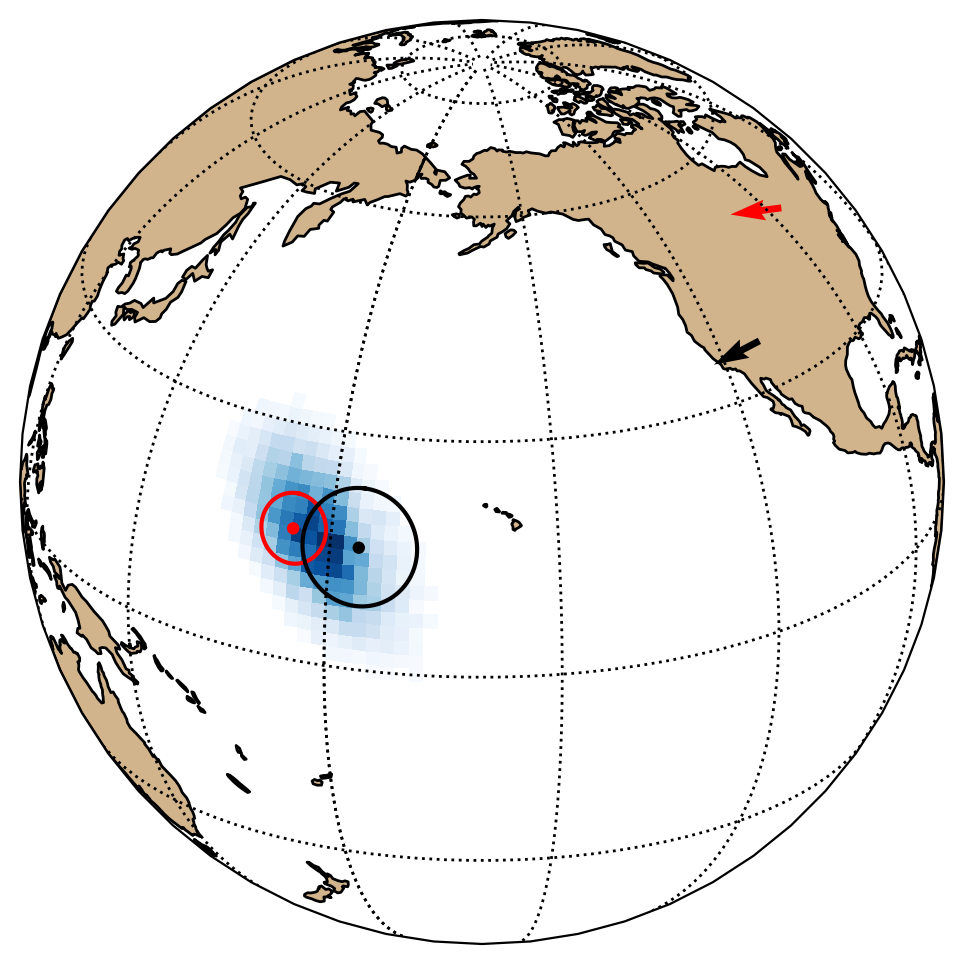

In [25]:
ax = ipmag.make_orthographic_map(figsize=(6,6), central_latitude=25, central_longitude=-160)

# now let's plot the declination of the directions at each site as a vector

ax.quiver(np.array([Mich_slon]), np.array([Mich_slat]), np.array([np.sin(np.radians(Mich_dir_dec))]), np.array([np.cos(np.radians(Mich_dir_dec))]),
            color='r', transform=ccrs.PlateCarree())
ax.quiver(np.array([CB_slon]), np.array([CB_slat]), np.array([np.sin(np.radians(CB_dir_dec))]), np.array([np.cos(np.radians(CB_dir_dec))]),
            color='k', transform=ccrs.PlateCarree())
# ax.plot([-174.7, Mich_slon], [17.0, Mich_slat], color='k', transform=ccrs.Geodetic())

plot_distributions(ax, dipole_axis_resample.T[0]+180, -dipole_axis_resample.T[1], cmap='Blues', resolution=100)

ipmag.plot_pole(ax, Mich_plon, Mich_plat, Michi_A95, color='r', edgecolor='none')
ipmag.plot_pole(ax, CB_plon, CB_plat, CB_A95, color='k', edgecolor='none')
plt.show()

### now let's calculate the posterior likelihood for the dipole model

In [26]:
dipole_resample_plons = dipole_axis_resample.T[0]+180
dipole_resample_plats = -dipole_axis_resample.T[1]

Mich_pred_decs = calculate_dipole_azimuth(Mich_slat, Mich_slon, dipole_resample_plats, dipole_resample_plons)

Mich_lats = np.array([90-calc_angle(dipole_resample_plon, 
                                    dipole_resample_plat, 
                                    Mich_slon, Mich_slat) for dipole_resample_plon, dipole_resample_plat in zip(dipole_resample_plons, dipole_resample_plats)]) 
Mich_pred_incs = calc_pinc(Mich_lats)
Mich_pred_incs = [inc if inc > 0 else -inc for inc in Mich_pred_incs]
CB_pred_decs = calculate_dipole_azimuth(CB_slat, CB_slon, dipole_resample_plats, dipole_resample_plons)

CB_lats = np.array([90-calc_angle(dipole_resample_plon, 
                                    dipole_resample_plat, 
                                    CB_slon, CB_slat) for dipole_resample_plon, dipole_resample_plat in zip(dipole_resample_plons, dipole_resample_plats)]) 
CB_pred_incs = calc_pinc(CB_lats)
CB_pred_incs = [inc if inc > 0 else -inc for inc in CB_pred_incs]
dipole_resample_likelihood = [fisher_logp([Mich_dir_dec, Mich_dir_inc], Mich_dir_k, [Mich_pred_dec, Mich_pred_inc]) +\
                                   fisher_logp([CB_dir_dec, CB_dir_inc], CB_dir_k, [CB_pred_dec, CB_pred_inc]) \
                                    for Mich_pred_dec, Mich_pred_inc, CB_pred_dec, CB_pred_inc in zip(Mich_pred_decs, Mich_pred_incs, CB_pred_decs, CB_pred_incs)]

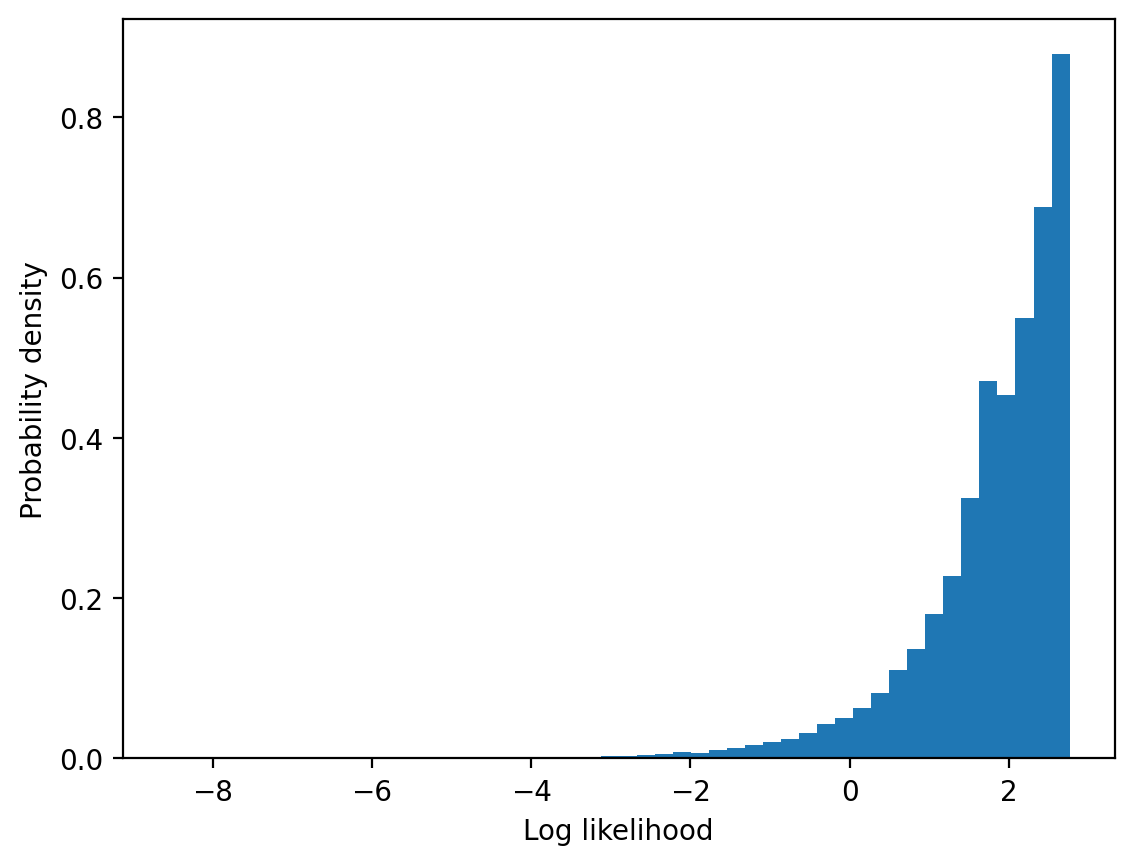

In [27]:
plt.hist(dipole_resample_likelihood, bins=50, density=True);
plt.xlabel('Log likelihood')
plt.ylabel('Probability density')
plt.show()

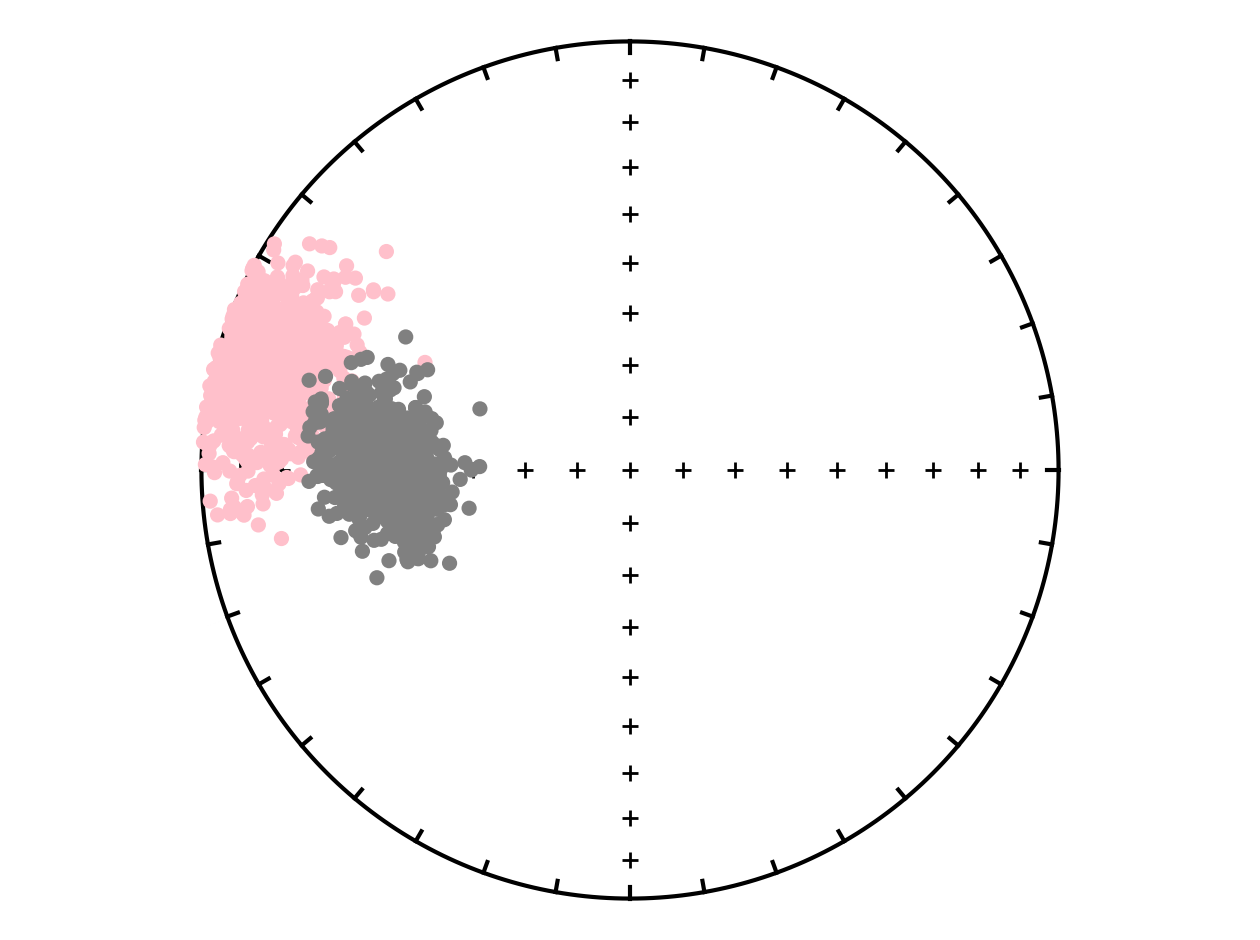

In [29]:
ipmag.plot_net()
ipmag.plot_di_mean(Mich_dir_dec, Mich_dir_inc, Mich_dir_a95, color='r')
ipmag.plot_di_mean(CB_dir_dec, CB_dir_inc, CB_dir_a95, color='k')

ipmag.plot_di(Mich_pred_decs[::100], Mich_pred_incs[::100], color='pink')
ipmag.plot_di(CB_pred_decs[::100], CB_pred_incs[::100], color='grey')

## Now let's invert for the best fit normal quadrupole location using bayesian_pep

In [111]:
def calc_normal_quadrupole_dec(lat, lon):
    '''
    input: lat, lon in degrees
    output: calcualted declination for a normal quadrupole model in degrees
    '''

    lat = lat*d2r
    lon = lon*d2r
    colat = np.pi/2-lat
    tan_dec = 1/np.cos(colat)*np.tan(2*lon)
    dec = np.arctan(tan_dec)
    return dec*r2d

def calc_normal_quadrupole_inc(lat, lon):
    '''
    input: lat, lon in degrees
    output: calcualted inclination for a normal quadrupole model in degrees
    '''

    lat = lat*d2r
    lon = lon*d2r
    colat = np.pi/2 - lat
    tan_I = -1.5*(np.sin(colat)*np.cos(2*lon))/(1-np.sin(colat)**2*np.cos(2*lon)**2)**0.5
    I = np.arctan(tan_I)*r2d
    return I

def calculate_pole_to_great_circle(lat1, lon1, lat2, lon2):
    '''
    input: lat1, lon1, lat2, lon2 in degrees
    output: pole to great circle angle in cartesian coordinates
    '''
    cart1 = spherical_to_cartesian(lon1, lat1)
    cart2 = spherical_to_cartesian(lon2, lat2)
    pole = np.cross(cart1, cart2)
    # pole = pole/np.linalg.norm(pole)
    return pole 


In [108]:
quadrupole_decs = calc_normal_quadrupole_dec(lats, lons)

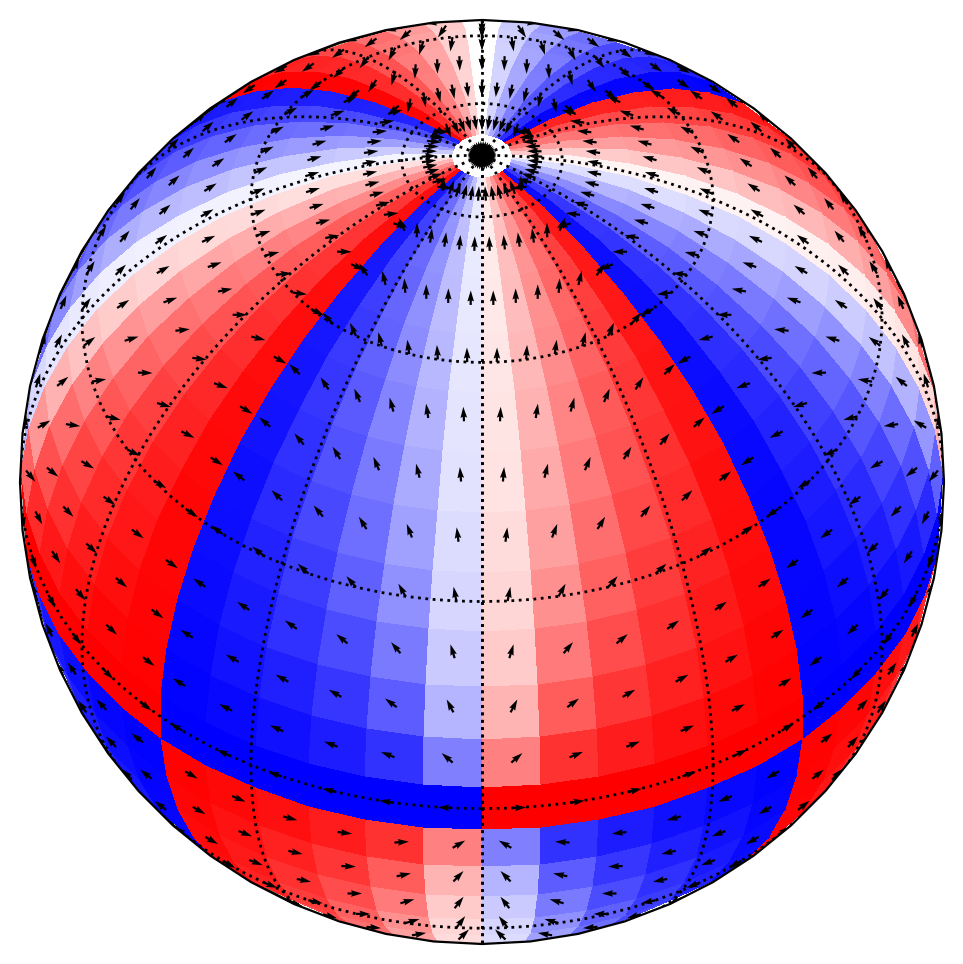

In [109]:
# illustrate the inclinations

ax = ipmag.make_orthographic_map(figsize=(6,6), central_latitude=45, central_longitude=180)

ax.pcolormesh(lons, lats, quadrupole_decs, vmin=np.min(quadrupole_decs), vmax=np.max(quadrupole_decs), 
              cmap='bwr', transform=ccrs.PlateCarree())

ax.quiver(lons, lats, np.sin(np.radians(quadrupole_decs)), np.cos(np.radians(quadrupole_decs)),
            color='k', transform=ccrs.PlateCarree())

plt.show()

In [201]:
with pm.Model() as quadrupole_model:
    # let's define a prior for the quadrupole location with a Watson girdle with very small k 
    quadrupole_axis = Watson_Girdle('quadrupole_axis', lon_lat = [1.,1.], k=-0.1, testval = np.array([1., 1.]), shape = 2)
    quadrupole_axis_cart = spherical_to_cartesian(quadrupole_axis[0], quadrupole_axis[1])
    # let's also set a prior for the quadrupole 0 meridian angle
    # because the meridian has to be perpendicular to the quadrupole axis
    # we can set a uniform prior between 0 and 360 for the angle offset for calculating the apparent longitude
    meridian_angle = pm.Uniform('meridian_angle', 0., 360.)

    # with this pole location and longitude offset, we can then calculate the expected directions at the sites
    Mich_lat = 90-calc_angle(quadrupole_axis[0], quadrupole_axis[1], Mich_slon, Mich_slat)
    # calculate the pole to great circle angle between the site location and the quadrupole axis
    Mich_great_circle_pole = calculate_pole_to_great_circle(Mich_slat, Mich_slon, quadrupole_axis[1], quadrupole_axis[0])

    # calculate predicted declination
    Mich_pred_dec = calc_normal_quadrupole_dec(Mich_lat, meridian_angle)
    #calculate predicted inclination
    Mich_pred_inc = calc_normal_quadrupole_inc(Mich_lat, meridian_angle)

    # use the observed declination and inclination to calculate the likelihood
    observed_dir = VMF('dir_Mich', [Mich_pred_dec, Mich_pred_inc], k = Mich_dir_k, observed=[Mich_dir_dec, Mich_dir_inc])

    CB_lat = 90-calc_angle(quadrupole_axis[0], quadrupole_axis[1], CB_slon, CB_slat)
    # calculate the pole to great circle angle between the site location and the quadrupole axis
    CB_great_circle_pole = calculate_pole_to_great_circle(CB_slat, CB_slon, quadrupole_axis[1], quadrupole_axis[0])

    
    # let's then get the longitudinal (with respect to the quadrupole axis) offset of the site
    offset_angle = (np.arccos(np.dot(Mich_great_circle_pole, CB_great_circle_pole)) * r2d) % 360

    # now let's get the pole to the great circle for the two sites
    CB_Mich_great_circle_pole = calculate_pole_to_great_circle(CB_slat, CB_slon, Mich_slat, Mich_slon)

    # then let's calculate the distance between the sites' great circle pole and the quadrupole axis
    pole_distance = (np.arccos(np.dot(quadrupole_axis_cart, CB_Mich_great_circle_pole)) * r2d) % 360

    if T.lt(pole_distance, 90):
        offset_angle = offset_angle
    else:
        offset_angle = -offset_angle
    # if T.gt(offset_angle, 180):
    #     offset_angle = offset_angle-360
    
    # Mich_loc_cart = spherical_to_cartesian(Mich_slon, Mich_slat)
    # CB_loc_cart = spherical_to_cartesian(CB_slon, CB_slat)

    # if T.gt(np.dot(quadrupole_axis_cart, Mich_loc_cart), np.dot(quadrupole_axis_cart, CB_loc_cart)):
    #     offset_angle = -offset_angle
    # calculate predicted declination
    CB_pred_dec = calc_normal_quadrupole_dec(CB_lat, offset_angle+meridian_angle)
    #calculate predicted inclination
    CB_pred_inc = calc_normal_quadrupole_inc(CB_lat, offset_angle+meridian_angle)
    
    # use the observed declination and inclination to calculate the likelihood
    observed_dir = VMF('dir_CB', [CB_pred_dec, CB_pred_inc], k = CB_dir_k, observed=[CB_dir_dec, CB_dir_inc])
    
    #uncomment to run the model
    quadrupole_trace = pm.sample(50000, tune=50000, step = pm.Metropolis(), cores=12, chains=4, init='auto')

Multiprocess sampling (4 chains in 12 jobs)
CompoundStep
>Metropolis: [meridian_angle]
>Metropolis: [quadrupole_axis]


Sampling 4 chains for 50_000 tune and 50_000 draw iterations (200_000 + 200_000 draws total) took 160 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [202]:
# pm.save_trace(quadrupole_trace, 'code_output/quadrupole_trace', overwrite=1)

In [203]:
# quadrupole_trace_saved = pm.load_trace('code_output/quadrupole_trace',quadrupole_model)

In [204]:
quadrupole_axis_resample = quadrupole_trace[quadrupole_axis]
meridian_angle_resample = quadrupole_trace[meridian_angle]

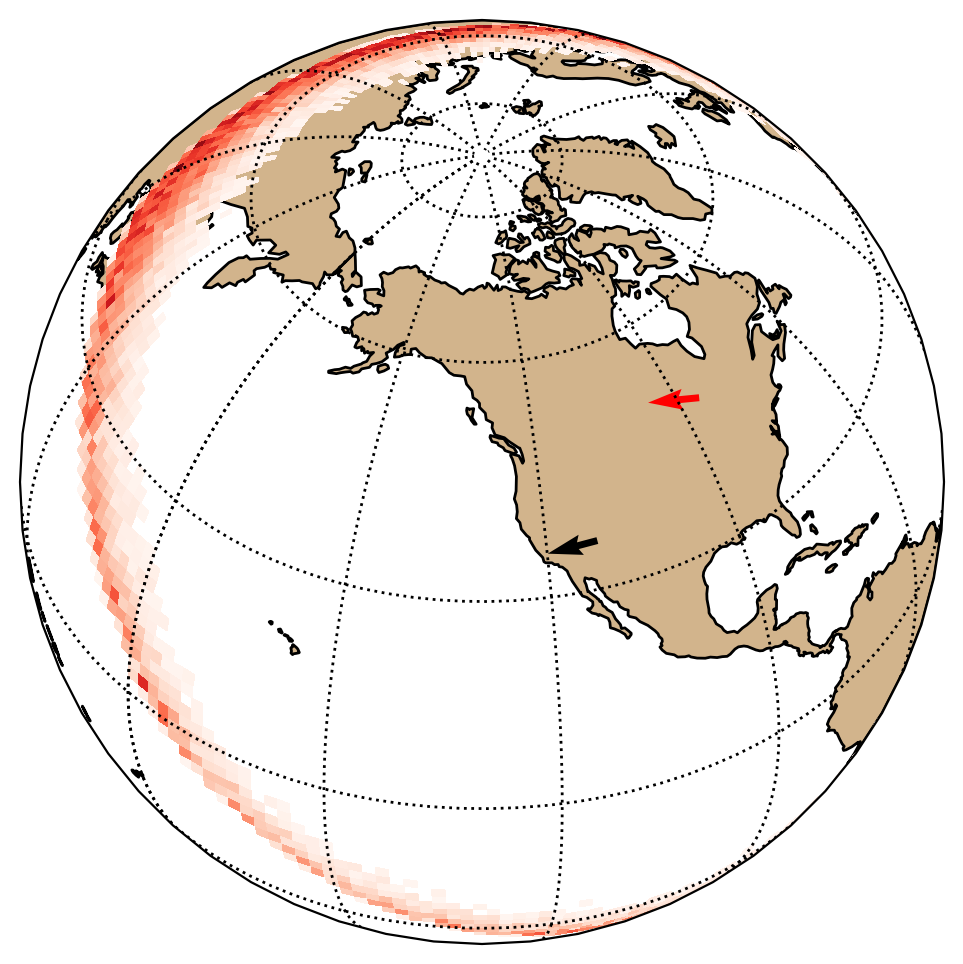

In [224]:
ax = ipmag.make_orthographic_map(figsize=(6,6), central_latitude=45, central_longitude=-130)

# now let's plot the declination of the directions at each site as a vector

ax.quiver(np.array([Mich_slon]), np.array([Mich_slat]), np.array([np.sin(np.radians(Mich_dir_dec))]), np.array([np.cos(np.radians(Mich_dir_dec))]),
            color='r', transform=ccrs.PlateCarree())
ax.quiver(np.array([CB_slon]), np.array([CB_slat]), np.array([np.sin(np.radians(CB_dir_dec))]), np.array([np.cos(np.radians(CB_dir_dec))]),
            color='k', transform=ccrs.PlateCarree())

plot_distributions(ax, quadrupole_axis_resample.T[0], quadrupole_axis_resample.T[1], cmap='Reds', resolution=100)

# ipmag.plot_pole(ax, Mich_plon, Mich_plat, Michi_A95, color='r', edgecolor='none')
# ipmag.plot_pole(ax, CB_plon, CB_plat, CB_A95, color='k', edgecolor='none')
plt.show()

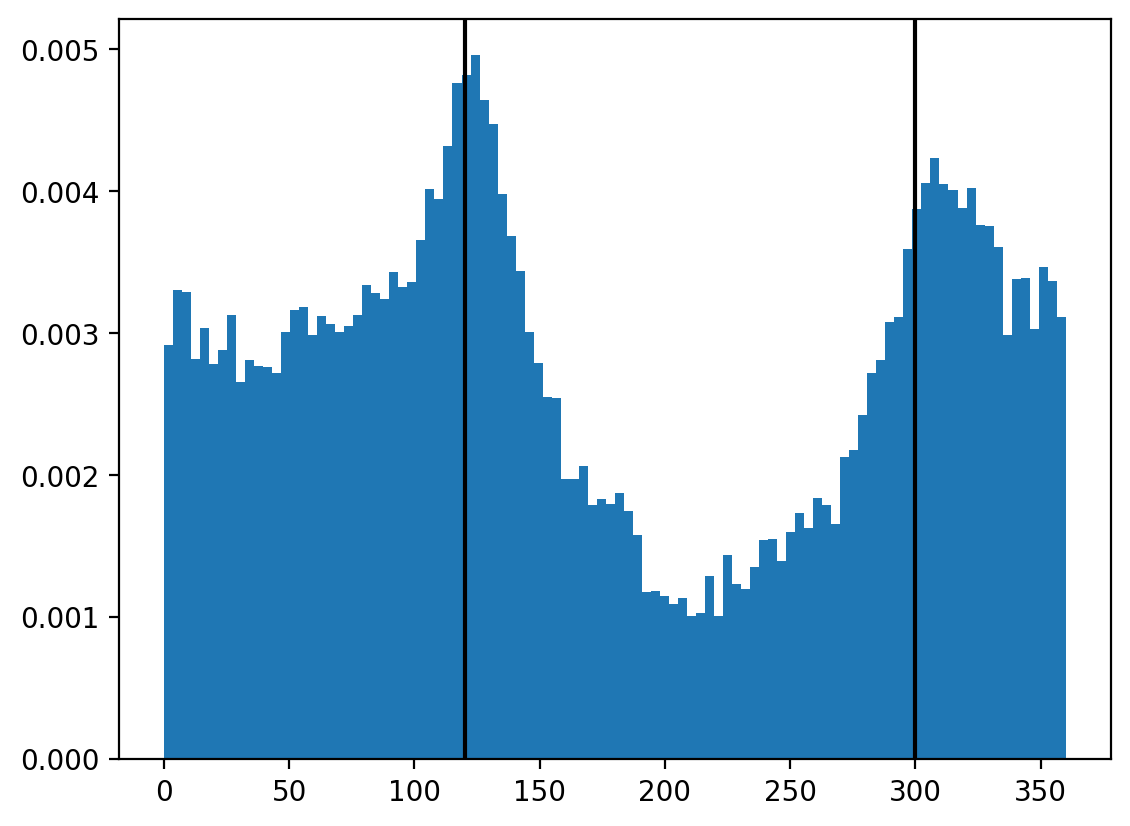

In [206]:
plt.hist(quadrupole_axis_resample.T[0]%360, bins=100, density=1)
plt.axvline(120, color='k')
plt.axvline(300, color='k')

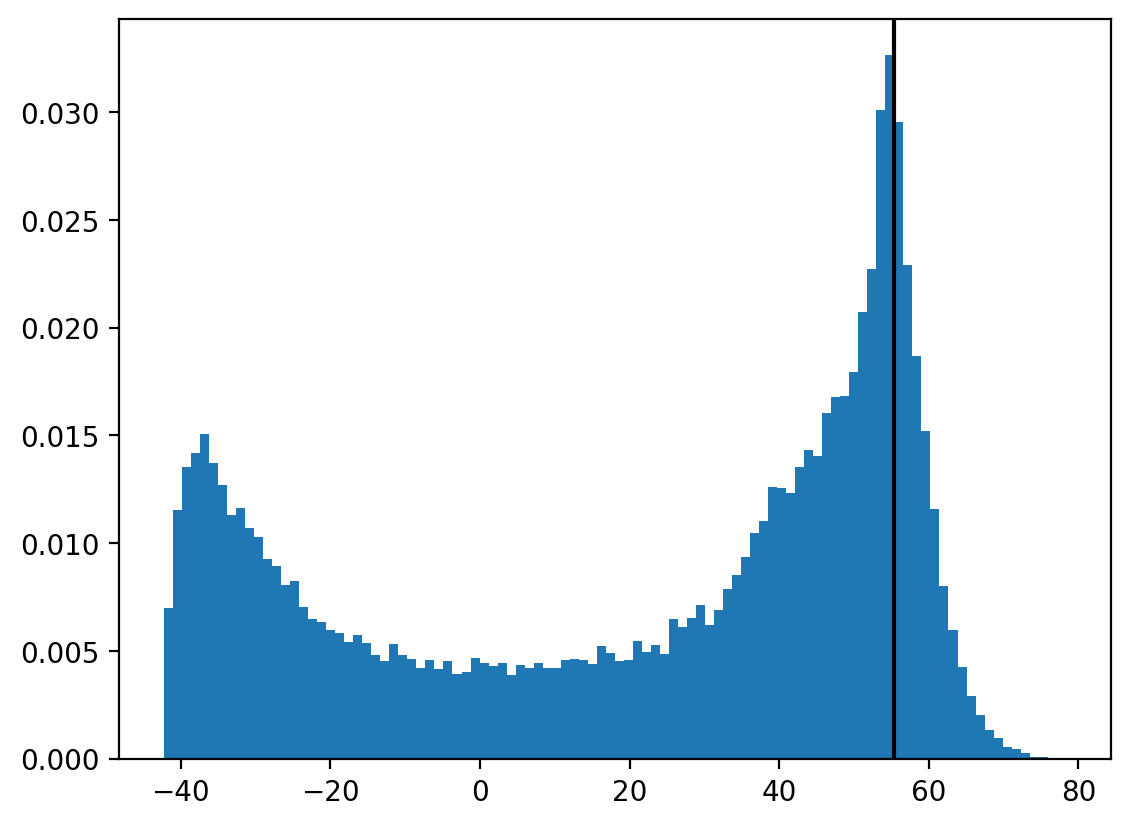

In [262]:
plt.hist(quadrupole_axis_resample.T[1], bins=100, density=1);
plt.axvline(quadrupole_axis_resample.T[1][8000], color='k')

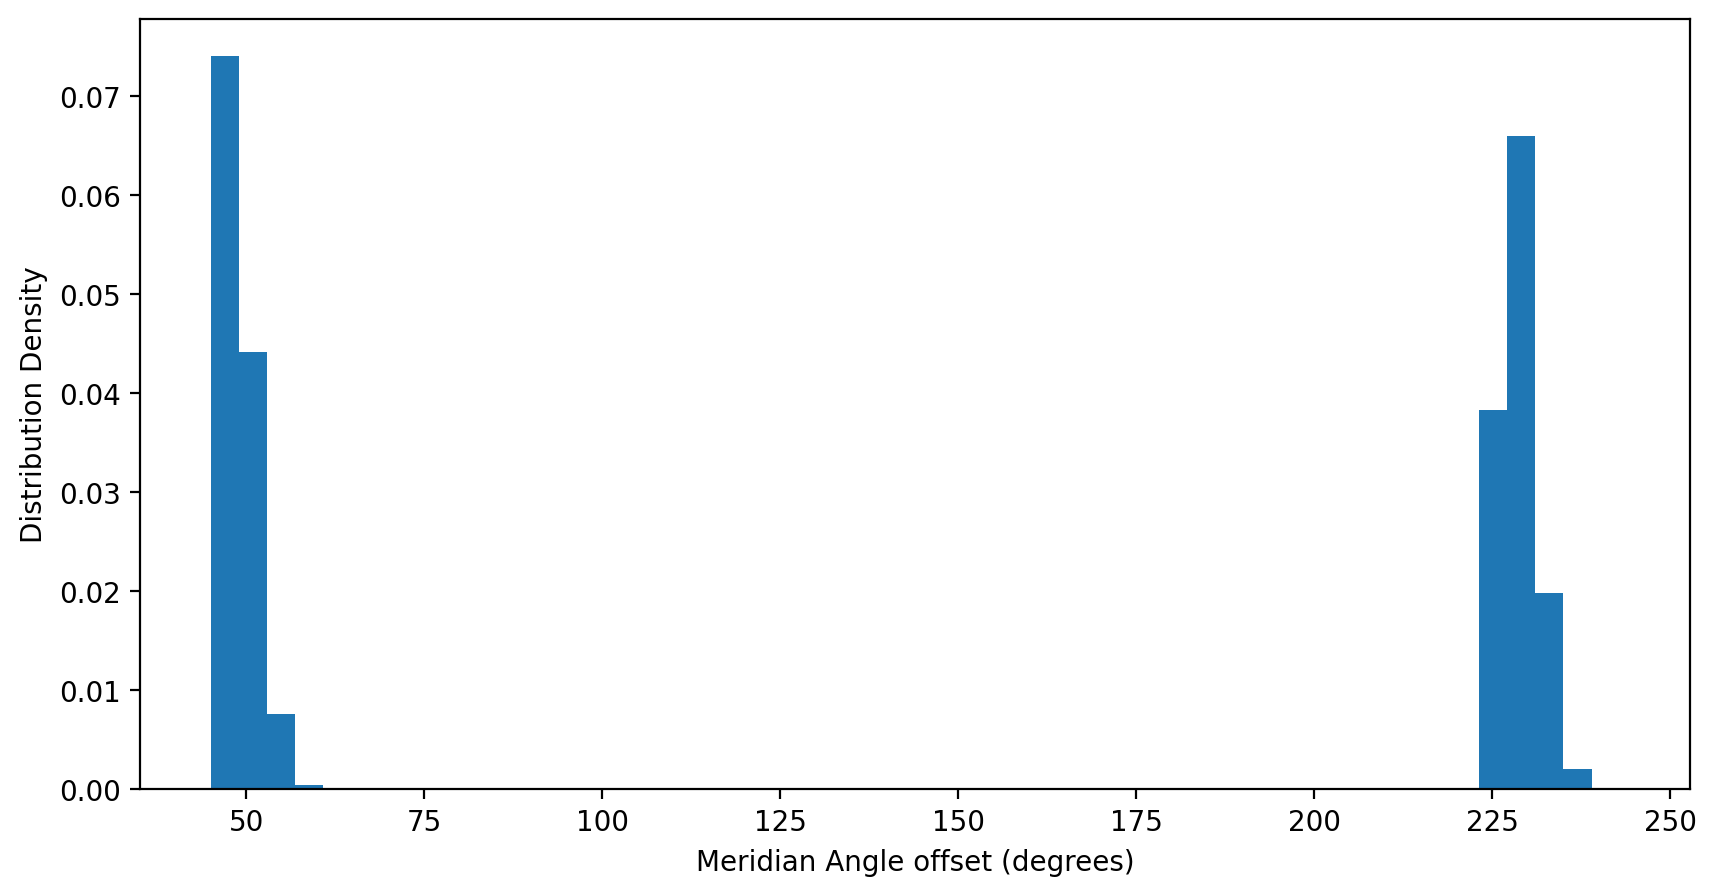

In [208]:
plt.figure(figsize=(10,5))
plt.hist(meridian_angle_resample, density=True, bins=50)

plt.xlabel('Meridian Angle offset (degrees)')
plt.ylabel('Distribution Density')
plt.show()

In [233]:
quadrupole_axis_plons = quadrupole_axis_resample.T[0]%360
quadrupole_axis_plats = quadrupole_axis_resample.T[1]


quadrupole_axis_carts = np.array([spherical_to_cartesian(quadrupole_axis_plon, quadrupole_axis_plat) \
                                 for quadrupole_axis_plon, quadrupole_axis_plat in zip(quadrupole_axis_plons, quadrupole_axis_plats)])

Mich_lats = np.array([90-calc_angle(quadrupole_resample_plon, 
                                    quadrupole_resample_plat, 
                                    Mich_slon, Mich_slat) for quadrupole_resample_plon, quadrupole_resample_plat in zip(quadrupole_axis_plons, quadrupole_axis_plats)]) 

Mich_great_circle_pole = np.array([calculate_pole_to_great_circle(Mich_slat, Mich_slon, quadrupole_resample_plat, quadrupole_resample_plon) \
                                   for quadrupole_resample_plon, quadrupole_resample_plat in zip(quadrupole_axis_plons, quadrupole_axis_plats)])

quadru_Mich_pred_decs = np.array([calc_normal_quadrupole_dec(Mich_lat, meridian_angle) for Mich_lat, meridian_angle in zip(Mich_lats, meridian_angle_resample)])
quadru_Mich_pred_incs = np.array([calc_normal_quadrupole_inc(Mich_lat, meridian_angle) for Mich_lat, meridian_angle in zip(Mich_lats, meridian_angle_resample)])


CB_lat = np.array([90-calc_angle(quadrupole_resample_plon,
                                quadrupole_resample_plat,
                                CB_slon, CB_slat) for quadrupole_resample_plon, quadrupole_resample_plat in zip(quadrupole_axis_plons, quadrupole_axis_plats)])

CB_great_circle_pole = np.array([calculate_pole_to_great_circle(CB_slat, CB_slon, quadrupole_resample_plat, quadrupole_resample_plon) \
                                 for quadrupole_resample_plon, quadrupole_resample_plat in zip(quadrupole_axis_plons, quadrupole_axis_plats)])

offset_angles = np.array([(np.arccos(np.dot(Mich_great_circle_pole, CB_great_circle_pole)) * r2d) % 360 \
                         for Mich_great_circle_pole, CB_great_circle_pole in zip(Mich_great_circle_pole, CB_great_circle_pole)])

CB_Mich_great_circle_pole = calculate_pole_to_great_circle(CB_slat, CB_slon, Mich_slat, Mich_slon)

pole_distance = np.array([(np.arccos(np.dot(quadrupole_axis_cart, CB_Mich_great_circle_pole)) * r2d) % 360 \
                            for quadrupole_axis_cart in quadrupole_axis_carts])

offset_angles = [offset_angle if pole_distance < 90 else -offset_angle for offset_angle, pole_distance in zip(offset_angles, pole_distance)]

quadru_CB_pred_decs = np.array([calc_normal_quadrupole_dec(CB_lat, offset_angle+meridian_angle) for CB_lat, offset_angle, meridian_angle in zip(CB_lat, offset_angle, meridian_angle_resample)])
quadru_CB_pred_incs = np.array([calc_normal_quadrupole_inc(CB_lat, offset_angle+meridian_angle) for CB_lat, offset_angle, meridian_angle in zip(CB_lat, offset_angle, meridian_angle_resample)])

quadrupole_resample_likelihood = [fisher_logp([Mich_dir_dec, Mich_dir_inc], Mich_dir_k, [quadru_Mich_pred_dec, quadru_Mich_pred_inc]) +\
                                   fisher_logp([CB_dir_dec, CB_dir_inc], CB_dir_k, [quadru_CB_pred_dec, quadru_CB_pred_inc]) \
                                    for quadru_Mich_pred_dec, quadru_Mich_pred_inc, quadru_CB_pred_dec, quadru_CB_pred_inc \
                                        in zip(quadru_Mich_pred_decs, quadru_Mich_pred_incs, quadru_CB_pred_decs, quadru_CB_pred_incs)]

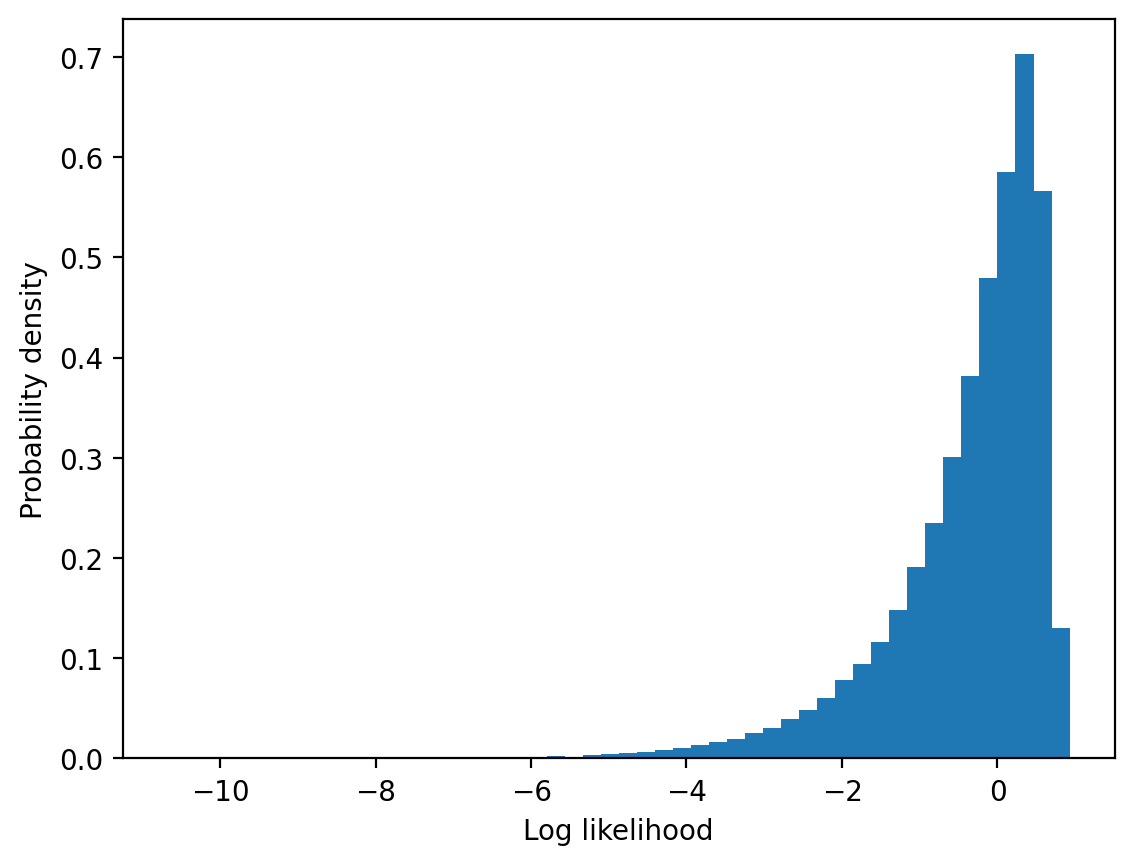

In [234]:
plt.hist(quadrupole_resample_likelihood, bins=50, density=True);
plt.xlabel('Log likelihood')
plt.ylabel('Probability density')
plt.show()

### plot example quadrupole axix and the corresponding predicted site directions

In [ ]:
quadrupole_axis_example_index = 8000

quadrupole_axis_example_lon = quadrupole_axis_resample.T[0][quadrupole_axis_example_index]%360
quadrupole_axis_example_lat = quadrupole_axis_resample.T[1][quadrupole_axis_example_index]
quadrupole_meridian_example = meridian_angle_resample[quadrupole_axis_example_index]

quadrupole_axis_example_lon, quadrupole_axis_example_lat, quadrupole_meridian_example

(41.31527850272164, 55.37802543559759, 50.60516387413115)

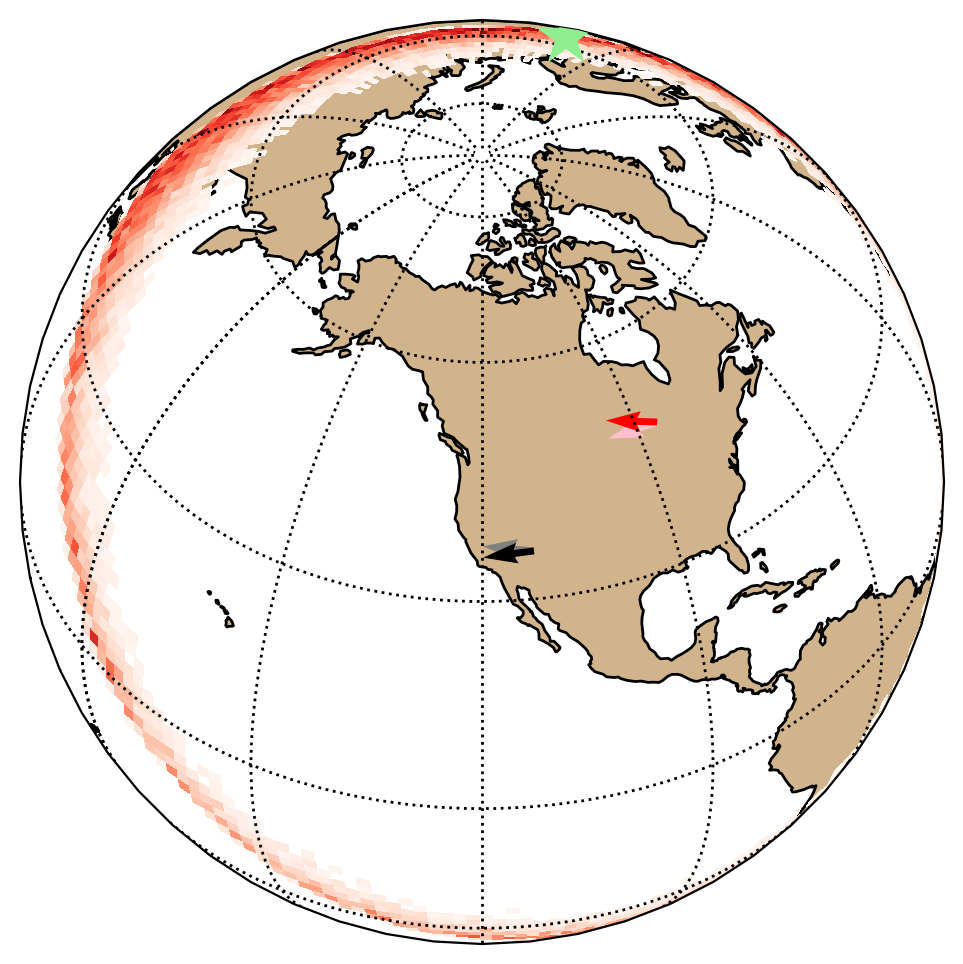

In [268]:
ax = ipmag.make_orthographic_map(figsize=(6,6), central_latitude=45, central_longitude=-120)

# now let's plot the declination of the directions at each site as a vector
plot_distributions(ax, quadrupole_axis_resample.T[0], quadrupole_axis_resample.T[1], cmap='Reds', resolution=100)

ax.quiver(np.array([Mich_slon]), 
          np.array([Mich_slat]), 
          np.array([np.sin(np.radians(quadru_Mich_pred_decs[quadrupole_axis_example_index]))]), 
          np.array([np.cos(np.radians(quadru_Mich_pred_decs[quadrupole_axis_example_index]))]),
            color='pink', transform=ccrs.PlateCarree())

ax.quiver(np.array([CB_slon]), 
          np.array([CB_slat]), 
          np.array([np.sin(np.radians(quadru_CB_pred_decs[quadrupole_axis_example_index]))]), 
          np.array([np.cos(np.radians(quadru_CB_pred_decs[quadrupole_axis_example_index]))]),
            color='grey', transform=ccrs.PlateCarree())

ax.quiver(np.array([Mich_slon]), np.array([Mich_slat]), np.array([np.sin(np.radians(Mich_dir_dec))]), np.array([np.cos(np.radians(Mich_dir_dec))]),
            color='r', transform=ccrs.PlateCarree())
ax.quiver(np.array([CB_slon]), np.array([CB_slat]), np.array([np.sin(np.radians(CB_dir_dec))]), np.array([np.cos(np.radians(CB_dir_dec))]),
            color='k', transform=ccrs.PlateCarree())


ipmag.plot_pole(ax, quadrupole_axis_example_lon, quadrupole_axis_example_lat, 0, markersize=500, marker='*', color='lightgreen', edgecolor='none')

# ipmag.plot_pole(ax, Mich_plon, Mich_plat, Michi_A95, color='r', edgecolor='none')
# ipmag.plot_pole(ax, CB_plon, CB_plat, CB_A95, color='k', edgecolor='none')
plt.show()

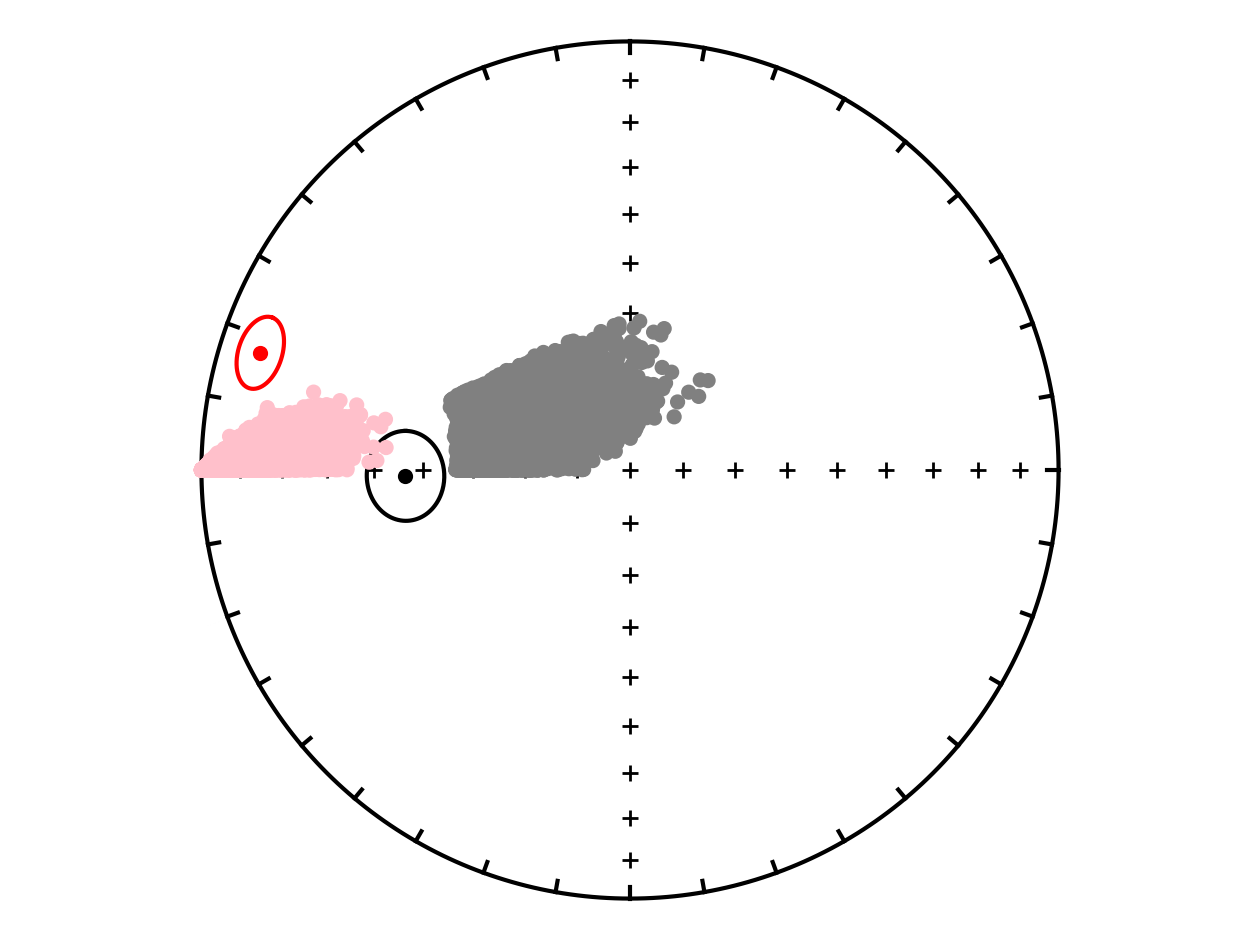

In [271]:
ipmag.plot_net()
ipmag.plot_di_mean(Mich_dir_dec, Mich_dir_inc, Mich_dir_a95, color='r')
ipmag.plot_di_mean(CB_dir_dec, CB_dir_inc, CB_dir_a95, color='k')

ipmag.plot_di(quadru_Mich_pred_decs[::10], quadru_Mich_pred_incs[::10], color='pink')
ipmag.plot_di(quadru_CB_pred_decs[::10], quadru_CB_pred_incs[::10], color='grey')